# Transfer Spending vs. Success in European Football (2000–2023)
**Author:** Efe ANIK  
**Tools:** Python (pandas, matplotlib, seaborn)  
**Notebook Type:** Exploratory Data Analysis + Visual Insights  
**Last Updated:** 07/07/2025

## 1. Project Description

This data analysis project explores the evolution of transfer spending in European football and investigates whether higher spending leads to better club performance.

### Objectives:
- Analyze how transfer spending has changed over time (2000–2023)
- Identify the most expensive seasons and growth trends
- Explore whether clubs that spend more actually perform better
  - Using **ELO ratings** as a success metric
 
---
**ELO ratings** are a statistical metric originally used in chess, but now widely adopted in football to track team strength based on match results, opponent difficulty, and consistency.

### Data Sources:
- Transfer data from Transfermarkt (2000-2023)(Kaggle dataset)
- Club ELO ratings dataset (2000-2023)(Kaggle dataset)

#### Variables
##### Transfer Dataset (2000–2023)

- `Transfer_Fee`: Transfer fee paid for the player
- `Transfer_Window`: Year of the transfer occurred
- `Club_Joined`: The club that signed the player
- `Club_Left`: The club that player left for the transfer
- `Position`: Player's position on the field (e.g. FW, MF, DF)
- `Age`: Player age at the time of the transfer
- `Market_Value`: Market value of the player at the time of transfer

##### ELO Ratings Dataset

- `date`: The date when the ELO rating was recorded
- `club`: Name of the football club
- `elo`: The ELO performance rating of the club on that date
- `Year`: Year from `date`
- `Avg_ELO`: Average ELO rating of the season (used for merging)

##### Merged Dataset (Used in Final Analysis)

- `Total_Spending_M€`: Total transfer spending of a club in a given year
- `Avg_ELO`: Average ELO rating of that club in the same year


### Tools:
- Python (pandas, matplotlib)
- Jupyter Notebook

---

This project combines data cleaning, aggregation, and visualization to answer:

> **Does spending more money in transfers bring more success?**


## Introduction

In modern football, clubs are spending more than ever before in the transfer market in pursuit of success.

With the emergence of wealthy clubs especially from leagues like the Saudi Pro League and rising fees each year, the question arises:

> **Does higher transfer spending actually lead to better performance?**

This project explores the relationship between club spending and on-pitch success, using over two decades of transfer data and club-level ELO performance ratings.

We also reflect briefly on whether key moments (e.g. blockbuster transfers) may have accelerated market inflation.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv(r"C:\Users\efean\Downloads\EFE PANDAS TRANSFERMARKT\All_Trans_2000_2024.csv")
df.head()

,Unnamed: 0,Player,Age,Club_Left,League_Left,Club_Joined,League_Joined,Transfer_Fee,Transfer_Window,Performance_Year
0,0,Luís Figo,27,FC Barcelona,LaLiga,Real Madrid,LaLiga,"60,00 Mio. €",2000,1999
1,1,Hernán Crespo,25,AC Parma,Serie A,Lazio Rom,Serie A,"56,81 Mio. €",2000,1999
2,2,Gabriel Batistuta,31,AC Florenz,Serie A,AS Rom,Serie A,"36,15 Mio. €",2000,1999
3,3,Nicolas Anelka,21,Real Madrid,LaLiga,FC Paris Saint-Germain,Division 1,"34,50 Mio. €",2000,1999
4,4,Rio Ferdinand,22,West Ham United,Premier League,Leeds United,Premier League,"26,00 Mio. €",2000,1999


## 2. Data Cleaning Part:

In this step, we clean the transfer fee data and convert all values into **million euros (Mio. €)** as float numbers.

We handle different formats:
- `"Mio. €"` → kept as-is
- `"Tsd. €"` → divided by 1000 (because Mio. € x 1000 = Tsd. €)
- `"Leihgebühr:..."` → extracted and cleaned (Loan fee)
- `"ablösefrei"` or `"?"` → considered as 0 (free or unknown)

In [2]:
df["Transfer_Fee"].unique()[500:550]

array(['Leihgebühr:5 Tsd. €', '1 Tsd. €', '720 Tsd. €', '500 €',
       '9,05 Mio. €', '7,20 Mio. €', 'Leihgebühr:7,00 Mio. €',
       '3,66 Mio. €', '37,50 Mio. €', '32,25 Mio. €', '24,50 Mio. €',
       '23,40 Mio. €', '21,80 Mio. €', '21,00 Mio. €', '19,75 Mio. €',
       '19,00 Mio. €', '9,90 Mio. €', '8,88 Mio. €', '8,60 Mio. €',
       '7,55 Mio. €', '6,35 Mio. €', '6,24 Mio. €', '5,95 Mio. €',
       '4,85 Mio. €', '4,75 Mio. €', '3,55 Mio. €',
       'Leihgebühr:3,50 Mio. €', 'Leihgebühr:2,50 Mio. €', '2,45 Mio. €',
       '2,15 Mio. €', '1,53 Mio. €', '1,33 Mio. €', '982 Tsd. €',
       'Leihgebühr:730 Tsd. €', '725 Tsd. €', '723 Tsd. €', '520 Tsd. €',
       '490 Tsd. €', '480 Tsd. €', '440 Tsd. €', 'Leihgebühr:280 Tsd. €',
       'Leihgebühr:241 Tsd. €', 'Leihgebühr:215 Tsd. €', '215 Tsd. €',
       '206 Tsd. €', '199 Tsd. €', '189 Tsd. €', 'Leihgebühr:170 Tsd. €',
       '166 Tsd. €', '134 Tsd. €'], dtype=object)

In [12]:
def convert_transfer_fee(val):
    if pd.isna(val):
        return 0.0

    val = str(val).strip().lower()

    if "ablösefrei" in val or "?" in val:
        return 0.0

    if "leihgebühr" in val:
        val = val.split(":")[-1].strip()


    if "tsd" in val:
        val = (
            val.replace("tsd. €", "")
            .replace("tsd €", "")
            .replace("tsd.", "")
            .replace("tsd", "")
            .replace(",", ".")
            .strip()
        )
        try:
            return float(val) / 1000
        except:
            return 0.0

    if "mio" in val:
        val = (
            val.replace("mio. €", "")
            .replace("mio €", "")
            .replace("mio.", "")
            .replace("mio", "")
            .replace(",", ".")
            .strip()
        )
        try:
            return float(val)
        except:
            return 0.0

    try:
        return float(val.replace(",", "."))
    except:
        return 0.0


In [16]:
df["Transfer_Fee_Clean"] = df["Transfer_Fee"].apply(convert_transfer_fee)
df.drop(columns=["Transfer_Fee"], inplace=True)
df.rename(columns={"Transfer_Fee_Clean": "Transfer_Fee"}, inplace=True)
df

,Unnamed: 0,Player,Age,Club_Left,League_Left,Club_Joined,League_Joined,Transfer_Window,Performance_Year,Transfer_Fee
0,0,Luís Figo,27,FC Barcelona,LaLiga,Real Madrid,LaLiga,2000,1999,60.000
1,1,Hernán Crespo,25,AC Parma,Serie A,Lazio Rom,Serie A,2000,1999,56.810
2,2,Gabriel Batistuta,31,AC Florenz,Serie A,AS Rom,Serie A,2000,1999,36.150
3,3,Nicolas Anelka,21,Real Madrid,LaLiga,FC Paris Saint-Germain,Division 1,2000,1999,34.500
4,4,Rio Ferdinand,22,West Ham United,Premier League,Leeds United,Premier League,2000,1999,26.000
...,...,...,...,...,...,...,...,...,...,...
43299,43299,Habib Maïga,28,FC Metz,Ligue 1,Ferencvárosi TC,NB I.,2023,2022,0.400
43300,43300,Agustín Martegani,23,CA San Lorenzo de Almagro,Liga Profesional,US Salernitana 1919,Serie A,2023,2022,0.400
43301,43301,Sergio León,34,Real Valladolid,LALIGA HYPERMOTI,FC Elche,LALIGA HYPERMOTI,2023,2022,0.400
43302,43302,Zé Carlos,21,Varzim SC,Liga 3,Vitória Guimarães SC,Liga Portugal,2023,2022,0.400


## 3. Transfer Spending Trend Over Time (2000–2023)

In this step, we analyze how total football transfer spending has changed over the last two decades.

- The data is grouped by year (`Transfer_Window`) and summed to compute total spending per season (in M€).

In [22]:
annual_spending = (
    df.groupby("Transfer_Window")["Transfer_Fee"]
    .sum()
    .reset_index()
    .sort_values("Transfer_Window")
)
annual_spending.columns = ["Year", "Total_Spending_Million_Euro"]
annual_spending["Total_Spending_Million_Euro"] = annual_spending["Total_Spending_Million_Euro"].round(0).astype(int)


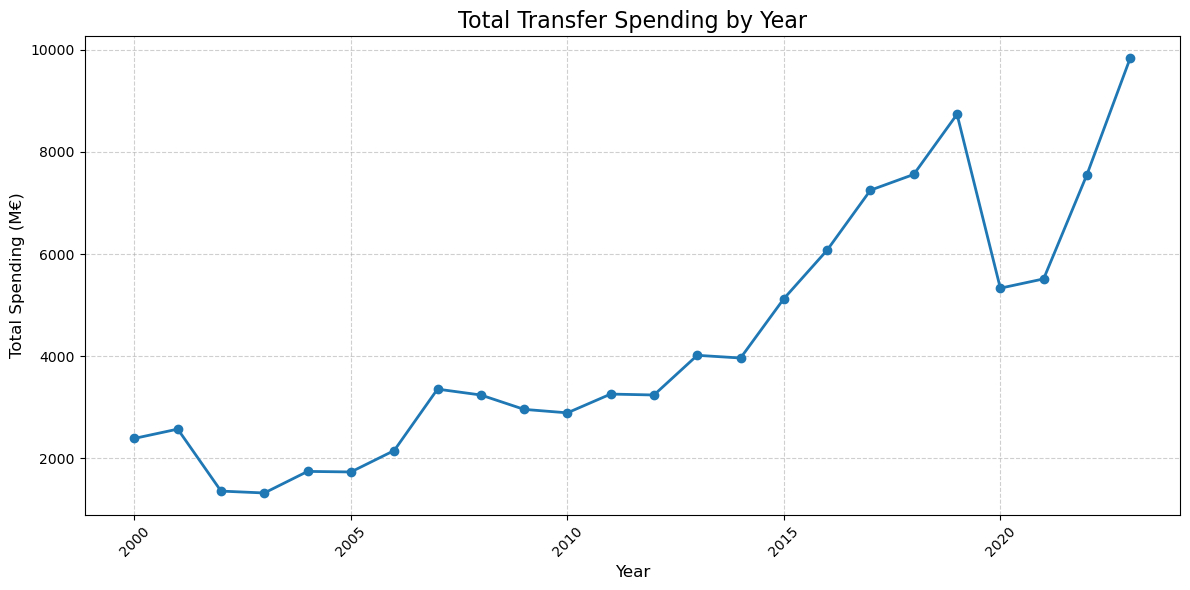

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(
    annual_spending["Year"],
    annual_spending["Total_Spending_Million_Euro"],
    marker="o",
    linewidth=2
)

plt.title("Total Transfer Spending by Year", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Total Spending (M€)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



The line chart above illustrates the evolution of total transfer spending in European football from 2000 to 2023.

#### Observations:
- Transfer spending has increased steadily over the last two decades.
- A notable drop in 2020 is observed due to the impact of the COVID-19 pandemic, which financially affected many clubs.
- A sharp rise is seen after 2015, peaking in 2023.
- The year 2023 has the highest spending on record, indicating the influence of new financial actors like Saudi clubs.

Notable player moves such as **Neymar’s 222M€ transfer to PSG in 2017** and **Cristiano Ronaldo’s move to Al Nassr in 2023** reflect major shifts in market dynamics and may have contributed to long-term inflation in spending.

This visualization highlights the **growing financial power, market inflation**, and the effect of global events (like pandemics) on football economics.


## 4. Preparing ELO Ratings (2000–2023)

The ELO dataset contains performance ratings for football clubs from 2000 to 2025 in the dataset. In this step, we will:

- Extract the **year** from the `date` column
- Filter the dataset to match our transfer data range (up to 2023)
- Group by **club and year**, calculating the **average ELO score per season**

This will allow us to compare a club's transfer spending with its relative strength.


In [28]:
elo = pd.read_csv(r"C:\Users\efean\Downloads\EFE PANDAS TRANSFERMARKT\EloRatings.csv")
elo


,date,club,country,elo
0,2000-07-01,Aachen,GER,1453.60
1,2000-07-01,Aalborg,DEN,1482.61
2,2000-07-01,Aalst,BEL,1337.53
3,2000-07-01,Aarhus,DEN,1381.46
4,2000-07-01,Aberdeen,SCO,1360.43
...,...,...,...,...
245028,2025-06-01,Wolfsburg,GER,1645.72
245029,2025-06-01,Wolves,ENG,1735.76
245030,2025-06-01,Zaragoza,ESP,1450.09
245031,2025-06-01,Zenit,RUS,1654.94


In [33]:
elo["Year"] = pd.to_datetime(elo["date"]).dt.year
elo = elo[elo["Year"] <= 2023]
elo_summary =(
    elo.groupby(["club", "Year"])["elo"]
    .mean()
    .reset_index()
    .rename(columns = {"club": "Club", "elo": "Avg_ELO"})
)
elo_summary.head(10)

,Club,Year,Avg_ELO
0,A. Sebatspor,2003,1368.922500
1,A. Sebatspor,2004,1444.437083
2,A. Sebatspor,2005,1382.987692
3,AEK,2000,1620.412500
4,AEK,2001,1653.377083
5,AEK,2002,1693.030000
6,AEK,2003,1714.854583
7,AEK,2004,1630.273333
8,AEK,2005,1583.940833
9,AEK,2006,1600.101667


## 5. Merging ELO Ratings with Transfer Spending

In this step, we merge the ELO summary with club-level transfer spending data.  
We group the cleaned transfer data by club and year to calculate total spending, then join it with the average ELO for the same club and season.

This gives us a **single dataset** to explore the relationship between spending and performance.


In [34]:
club_spending = (
    df.groupby(["Club_Joined", "Transfer_Window"])["Transfer_Fee"]
    .sum()
    .reset_index()
    .rename(columns={"Club_Joined": "Club", "Transfer_Window": "Year", "Transfer_Fee": "Total_Spending_M€"})
)
merged = pd.merge(club_spending, elo_summary, on=["Club", "Year"], how="inner")
merged.head()


,Club,Year,Total_Spending_M€,Avg_ELO
0,AIK,2007,0.8,1385.096667
1,AIK,2009,0.3,1412.684167
2,AIK,2010,0.0,1390.472917
3,AIK,2011,0.0,1363.360833
4,AIK,2012,0.0,1422.806250


## 6. Relationship Between Transfer Spending and ELO Rating

In this step, we visualize the relationship between club transfer spending and performance.

We use a scatter plot where:
- X-axis shows total transfer spending per club per season (in M€)
- Y-axis shows average ELO rating for the same club and year

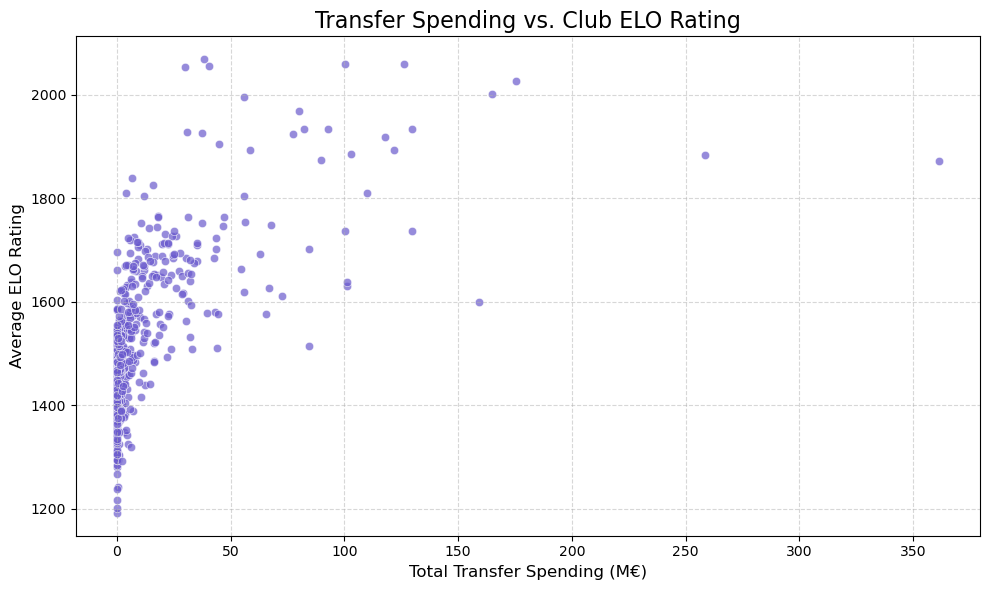

In [42]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=merged,
    x="Total_Spending_M€",
    y="Avg_ELO",
    alpha=0.7,
    color="slateblue"
)

plt.title("Transfer Spending vs. Club ELO Rating", fontsize=16)
plt.xlabel("Total Transfer Spending (M€)", fontsize=12)
plt.ylabel("Average ELO Rating", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


## 7. Correlation Between Transfer Spending and ELO

To assess the relationship between transfer spending and club strength,  
we calculate the **Pearson correlation coefficient** between the two variables.

Pearson correlation (r) measures linear association:
- **r ≈ 1** → strong positive correlation
- **r ≈ 0** → no correlation
- **r ≈ -1** → strong negative correlation

This gives us a summary of the trend observed in the scatter plot.


In [43]:
correlation = merged["Total_Spending_M€"].corr(merged["Avg_ELO"])
print(f"Pearson correlation (r) between transfer spending and ELO: {correlation:.3f}")


Pearson correlation (r) between transfer spending and ELO: 0.611


### 8. Interpretation of Correlation

The Pearson correlation coefficient between transfer spending and ELO rating is **r = 0.611**.

This indicates a **positive relationship**:
- In general, clubs that spend more, tend to achieve higher ELO ratings.
- However, the correlation is not perfect. Suggesting that **some clubs succeed without spending heavily**, and **others fail despite large budgets**.

This highlights that while money matters, it's not the **only factor in performance**.


## 9. Final Conclusion

This project analyzed over two decades of European football transfer data and linked it to performance metrics using ELO ratings.

### Key Insights:
- Transfer spending has increased significantly since the early 2000s, with a record in 2023.
- There is a **positive correlation** (r = 0.611) between transfer spending and performance.
- This suggests that **financial investment is generally effective**, but **not** a guarantee of success.

Finally, spending more tends to help — but **smart scouting, coaching, and team culture** are also critical in driving results.


## References & Data Sources

- **Football Transfer Data (2000–2024)**  
  [Football Transfer Model | Kaggle](https://www.kaggle.com/datasets/alexandergandji/football-transfer-model-2000-2024)

- **Club ELO Ratings**  
  [Club ELO Ratings Dataset | Kaggle](https://www.kaggle.com/datasets/guidoiosdagood/clubelo-ratings)